In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading & Preprocessing

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train_new/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train_new/malig',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/test_new/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/test_new/malig',224))

100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


# Create Label

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

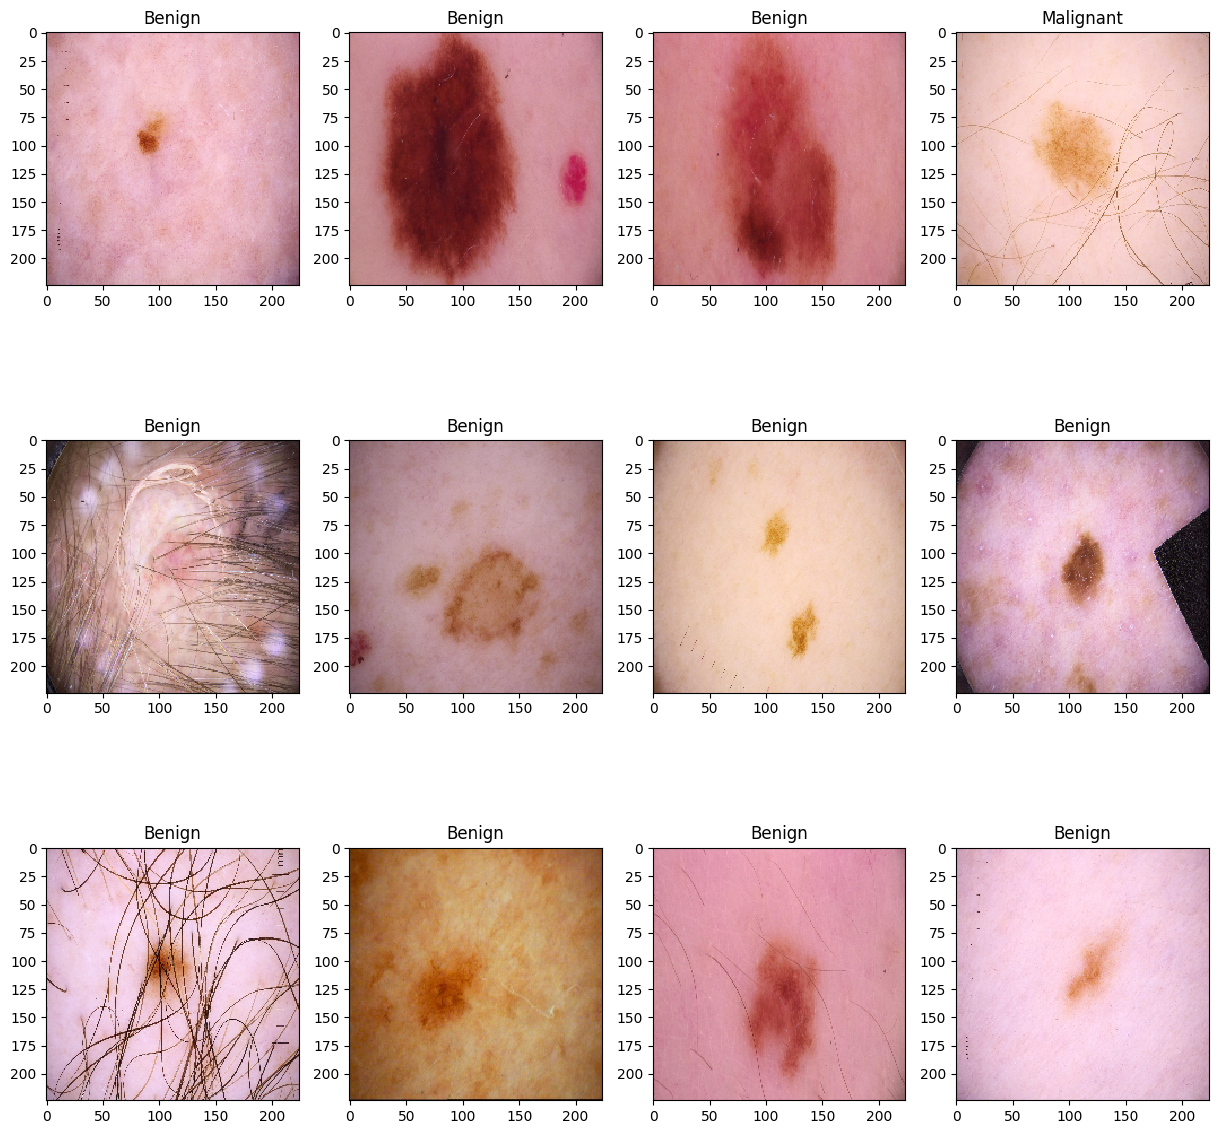

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Model: VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

for layer in vgg16.layers:
    layer.trainable = False

model = build_model(vgg16 ,lr = 1e-4)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

# Training & Evaluation

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learn_control = ReduceLROnPlateau(monitor='val_loss', patience=5,
                                  verbose=1, factor=0.2, min_lr=1e-7)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-15-0b1b2a35ebfa>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
100/99 [==============================] - ETA: 0s - loss: 0.8163 - accuracy: 0.5422
Epoch 1: val_loss improved from inf to 0.56640, saving model to model.h5
99/99 [==============================] - 99s 906ms/step - loss: 0.8163 - accuracy: 0.5422 - val_loss: 0.5664 - val_accuracy: 0.8030 - lr: 1.0000e-04
Epoch 2/50
100/99 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.6012
Epoch 2: val_loss did not improve from 0.56640
99/99 [==============================] - 74s 738ms/step - loss: 0.7311 - accuracy: 0.6012 - val_loss: 0.6335 - val_accuracy: 0.7067 - lr: 1.0000e-04
Epoch 3/50
100/99 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.6709
Epoch 3: val_loss improved from 0.56640 to 0.56290, saving model to model.h5
99/99 [==============================] - 75s 750ms/step - loss: 0.6670 - accuracy: 0.6709 - val_loss: 0.5629 - val_accuracy: 0.8349 - lr: 1.0000e-04
Epoch 4/50
100/99 [==============================] - ETA: 0s - loss: 0.

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

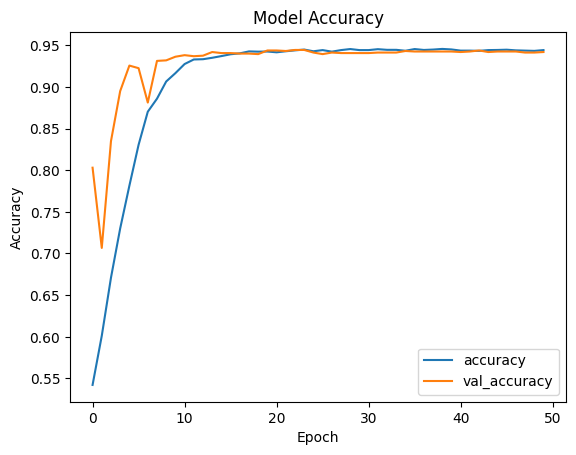

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<Axes: >

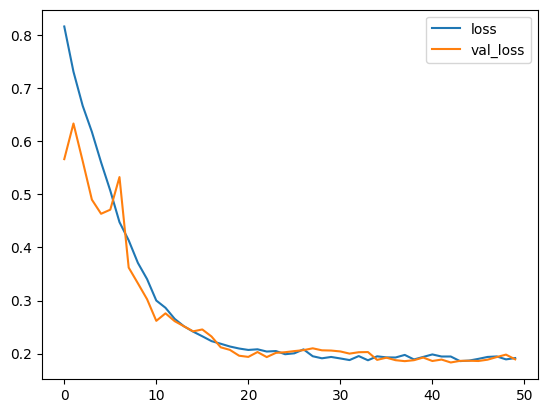

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [ ]:
Y_val_pred = model.predict(x_val)

50/50 [==============================] - 6s 128ms/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9418386491557224

In [ ]:
Y_pred = model.predict(X_test)

51/51 [==============================] - 7s 143ms/step


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-23-6b1627227319>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [03:04<00:00, 18.45s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[1543    8]
 [  45    5]]


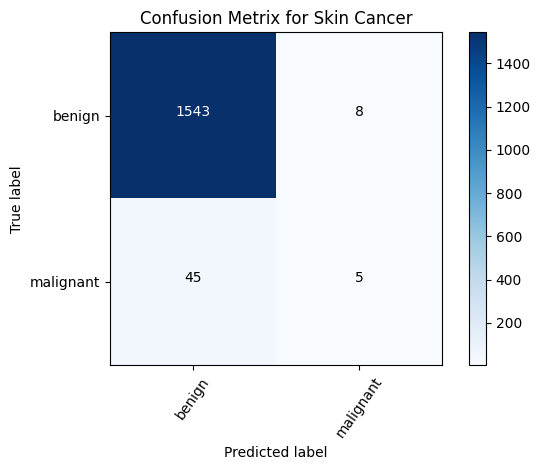

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[1550    1]
 [  50    0]]


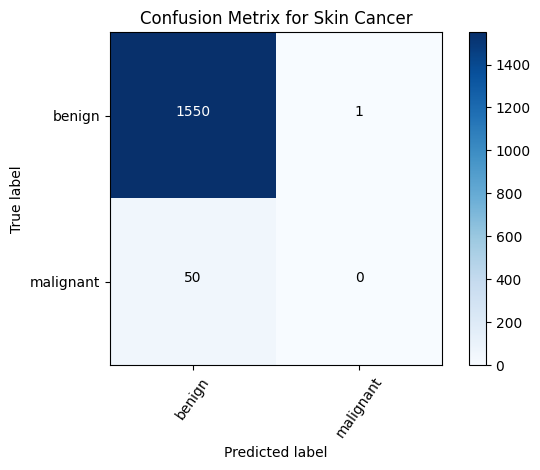

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.97      1.00      0.98      1551\n           1       0.00      0.00      0.00        50\n\n    accuracy                           0.97      1601\n   macro avg       0.48      0.50      0.49      1601\nweighted avg       0.94      0.97      0.95      1601\n'

### ROC and AUC

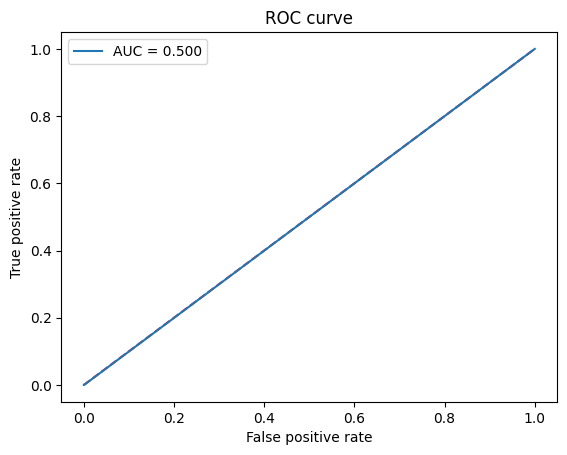

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

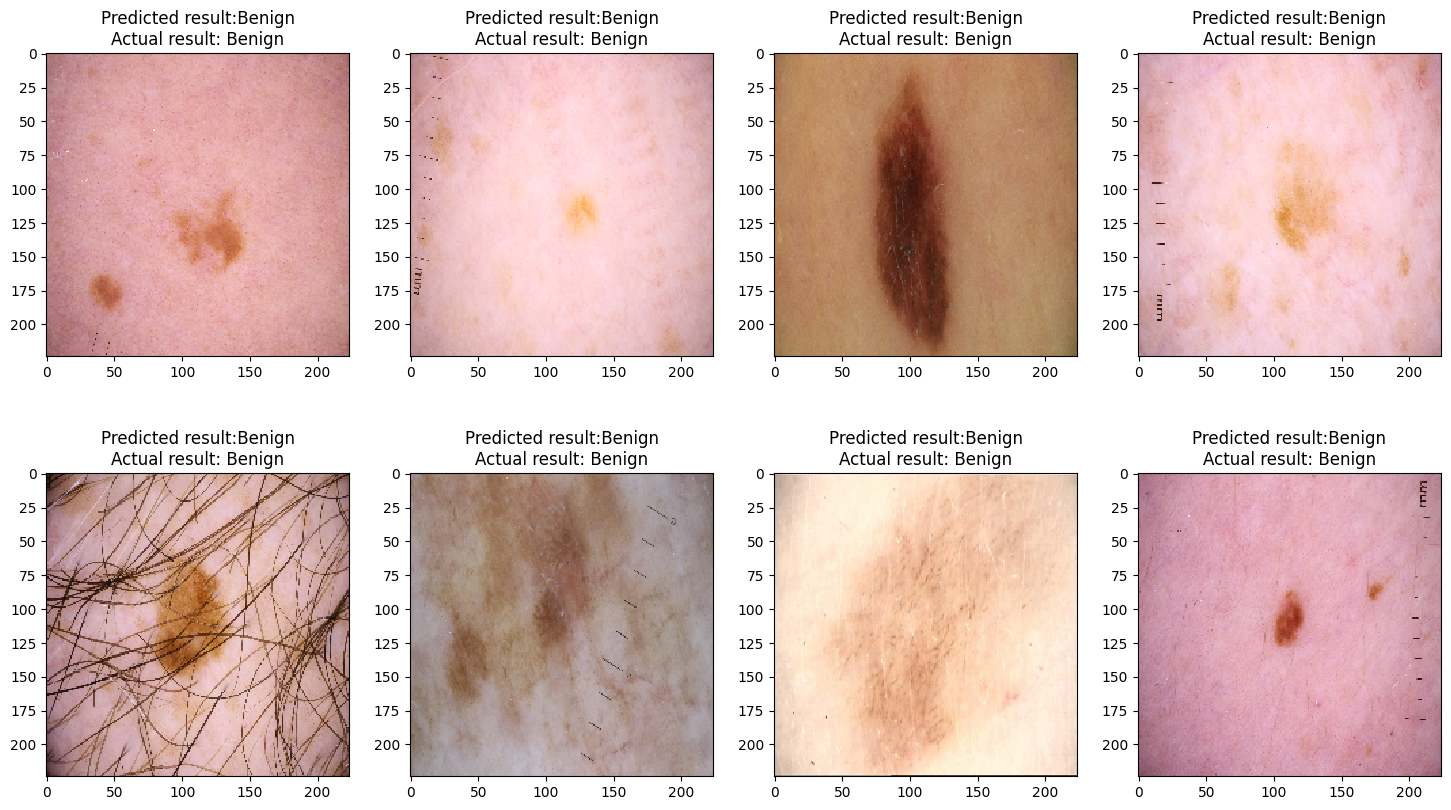

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

Improving the project by adding a hair removal code that does image processing and removes hair from the images in order to improve the model accuracy in understnading the images.


In [ ]:
def hair_removal(path):

  for num,img in tqdm(enumerate(os.listdir(path))):
      src = cv.imread(os.path.join('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train_new/benign,img))
      if src is not None:
        grayScale = cv.cvtColor( src, cv.COLOR_RGB2GRAY )
        # Kernel for the morphological filtering
      
        kernel = cv.getStructuringElement(1,(17,17))
        # Perform the blackHat filtering on the grayscale image to find the 
        # hair countours
      
        blackhat = cv.morphologyEx(grayScale, cv.MORPH_BLACKHAT, kernel)
        # intensify the hair countours in preparation for the inpainting 
        # algorithm
        ret,thresh2 = cv.threshold(blackhat,10,255,cv.THRESH_BINARY)
  
        # inpaint the original image depending on the mask
        dst = cv.inpaint(src,thresh2,1,cv.INPAINT_TELEA)
      
        cv.imwrite('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train_new/benign_hr/{i}'.format(i=img), dst, [int(cv.IMWRITE_JPEG_QUALITY), 90])
      

In [ ]:
def hair_removal(path):

  for num,img in tqdm(enumerate(os.listdir(path))):
      src = cv.imread(os.path.join('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train_new/malig,img))
      if src is not None:
        grayScale = cv.cvtColor( src, cv.COLOR_RGB2GRAY )
        # Kernel for the morphological filtering
      
        kernel = cv.getStructuringElement(1,(17,17))
        # Perform the blackHat filtering on the grayscale image to find the 
        # hair countours
      
        blackhat = cv.morphologyEx(grayScale, cv.MORPH_BLACKHAT, kernel)
        # intensify the hair countours in preparation for the inpainting 
        # algorithm
        ret,thresh2 = cv.threshold(blackhat,10,255,cv.THRESH_BINARY)
  
        # inpaint the original image depending on the mask
        dst = cv.inpaint(src,thresh2,1,cv.INPAINT_TELEA)
      
        cv.imwrite('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train_new/malig_hr/{i}'.format(i=img), dst, [int(cv.IMWRITE_JPEG_QUALITY), 90])

I couldn't implement the hair removal code as it is in openCV and each image takes nearly 5 to 10 minutes to process making it very hard to run even 1000 images as processing it itslef would take nearly 167 hours.

However I have tried to implement the hair removal code and a few outputs are shown in the project report.
I believe that processing the images by removing the hair mauy improve the result accuracy as the images would be more clearer and the affected area is highlighted better.
